# PCA for Dimensionality Reduction

In this notebook we explore Principal Component Analysis (PCA) and how it can be used to interpret high dimensional datasets in lower dimensions. 
To do so, we review concepts from linear algebra to get a fuller understanding of what's going on and why PCA works.

We first review how PCA is defined, what exactly the principal components are, and how PCA allows us to reduce the dimensionality of our dataset in a *good* way. 
Then we generate a few toy datasets to conduct PCA and see how we use the principal components to plot the data in fewer dimensions. 
Finally we conclude by taking a closer look into how PCA relates to the singular value decomposition of a dataset. 


Suppose we have a dataset $X$ of $n$ samples where each sample is described by $m$ real valued features. 
For the purpose of dimensionality reduction, our goal will be to find a matrix $Y$ of size $n \times d$ where $d << m $ and $Y$ approximates $X$ 
(that is, $Y$ still captures the underlying properties of the dataset.)
In this way, the $d$ remaining attributes would be the componenets of $X$ that capture the most relevant information of our dataset, or are its **principal components**.

There are many ways we could do so. One is simply dropping features that are not relevant,
while another is learning some dependencies between features(if they exist) and drop the unnecessary features.
Yet it's not clear how we can do either in a way where we don't discard information about our dataset that is necessary. 

To help motivate what PCA does, first observe that for each feature we can compute the mean of that feature:
$$
\bar{x} = \sum_{k=1}^{n}x_k
$$

We can then compute the variance of the feature (the spread each data point is from the mean):
$$
\sigma_{i}^{2} = \frac{1}{n}\sum_{k=1}^{n} (x_k - \bar{x})^2
$$

A low variance indicates the data points are close to the mean. 
If $\sigma_{i}^{2} \sim 0$ then a good approximation for each $x_i$ would be $\bar{x}_i$. 
In this case we could replace each of the $n$ values $x_i$ with a single value $\bar{x}_i$.

We can extend this to considering the variance between two features. This is defined as the **covariance** between two features:
$$
c_{xy} = \frac{1}{n} \sum_{k=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

Consider when the covariance is either negative, positive, or zero. These scenarios can occur when:
1. Greater (than the mean) values of one variable mostly correspond with lesser (than the mean) values of the other variable (negative times positive and positive times negative are negative values.)
2. Greater values of one variable mostly correspond with greater values of the other variable (similarly for lesser values - positive times positive and negative time negative are positive values.)
3. There is no correspondance between the values: we'll have a mix of 1. and 2. which when summed together will be zero.

In cases 1. and 2. there is either a negative or positive correlation between the two variables respectively. 
That is, knowing the value of one variable gives us an estimation of what the value of the other variable is. 
In this way analyzing the covariance between different features within our dataset will provide a means to reduce the number of features we have. 

## Covariance Matrix, Eigenvectors, and Eigenvalues

For $m$ features in our input matrix, we can compute the covariance between $m^2$ pairs of features.
This can be arranged into an $m \times m$ matrix $C$ where the main diagonal contains $c_{xx}$ for each feature $x$.
Because $c_{xy} = c_{yx}$ this matrix will be symmetric around the diagonal.

The covariance matrix of our dataset will be used to calculate its principal components by considering what the eigenvectors/values of the matrix are.
We define what these are here, and leave a deeper insight into why at the end of this notebook.

Consider a a vector $x$ in which we apply a linear transform to specified by a matrix $A$.
If we can find some constant value $\lambda$ such that this transform is equal to scaling the values of $x$ by this constant, then we say $x$ is an **eigenvector** of $A$ with $\lambda$ being its **eigenvalue** (together they are an **eigenpair**.)

$$
Ax = \lambda x
$$

A matrix may have multiple eigenvectors. 
What's key to note about an eigenvector is that when applying $A$ to the vector, the direction of the vector doesn't change - it is only scaled by some value. 
That is there is something fundamental about the direction of eigenvectors that any points in this direction are only scaled by applying $A$ to them. 


## Computing the Principal Components

We now define the steps for computing the principal components of our dataset. 
We then walk through these steps by running them on a toy dataset and visualizing how we use PCA to reduce the dimensions of our dataset. 
Finally we dive a little deeper into what's happening in these steps to justify them.

1. Normalize our data by mean-centering it.
2. Compute covariance matrix.
3. Compute eigenvectors and eigenvalues on convariance matrix.
4. Sort principal components by decreasing eigenvalues.
5. Select top 5 principal components as our new features.

We use several Python packages to assist with the computations (see the `requirements.txt` file to install.)

In [1]:
# Import packages that will be used
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
# Generate dataset containing n datapoints with 3 features
n = 25
x1 = np.random.normal(3, 1, n)
x2 = np.random.normal(1, 2, n)
# NOTE: For this toy example introduce a dependency for feature x3.
x3 = 3*x1 - x2 + np.random.normal(0, 0.5, n)
X = np.array([x1, x2, x3]).transpose()
X

array([[ 1.95712782,  0.2211375 ,  5.58875804],
       [ 2.9647479 ,  2.25561561,  6.45061275],
       [ 1.06021965,  1.08798434,  1.69267156],
       [ 3.67013986, -0.43275887, 10.35455798],
       [ 3.27655031,  1.65003215,  8.61208575],
       [ 3.3112854 ,  2.06104685,  7.77709326],
       [ 3.68640687,  2.83881645,  7.14053546],
       [ 2.52515852, -0.7615055 ,  8.97620189],
       [ 2.54656071,  1.64647488,  5.8202547 ],
       [ 3.56031928, -0.47436564, 11.00808059],
       [ 2.85616321,  3.1853447 ,  5.97891516],
       [ 3.44659657, -0.41303032, 10.54012791],
       [ 2.22468168,  6.707837  , -0.2785792 ],
       [ 2.01105138, -0.25284099,  7.13195969],
       [ 3.49402878, -1.99016224, 12.9790062 ],
       [ 3.08226664,  4.77220978,  4.5243987 ],
       [ 3.74758765,  3.46435435,  7.48609296],
       [ 2.49853855, -1.69582542,  8.94019025],
       [ 3.99074827,  3.76752714,  8.74025445],
       [ 1.82453891,  3.63610528,  1.49572969],
       [ 2.71483197, -0.54800995,  9.983

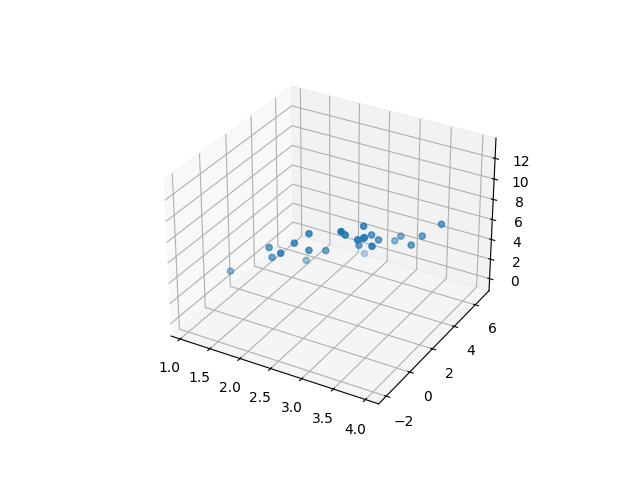

In [3]:
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])
plt.show()

# Because of our dependency, see how most datapoints seem to line on a 2D plane. 
# This suggests we should be able to reduce our data to 2 dimensions. 

In [4]:
# 1. normalize data
X = (X - X.mean(axis=0)) / X.std(axis=0)
X

array([[-1.37625818, -0.53066815, -0.59543651],
       [ 0.06196547,  0.39789285, -0.32115121],
       [-2.6564575 , -0.13502852, -1.83536625],
       [ 1.06880469, -0.82911455,  0.92127957],
       [ 0.50701576,  0.12149706,  0.36673769],
       [ 0.5565948 ,  0.30908926,  0.10100128],
       [ 1.09202336,  0.66407293, -0.10158327],
       [-0.56548117, -0.97915858,  0.48261767],
       [-0.53493282,  0.11987348, -0.52176269],
       [ 0.91205259, -0.84810439,  1.12926318],
       [-0.09302257,  0.82223271, -0.47126899],
       [ 0.74973081, -0.8201102 ,  0.98033721],
       [-0.99436594,  2.42994181, -2.4627169 ],
       [-1.29929054, -0.7469978 , -0.10431251],
       [ 0.81743304, -1.53993273,  1.75651036],
       [ 0.22970552,  1.54649758, -0.93416893],
       [ 1.17934957,  0.94957617,  0.00839043],
       [-0.60347712, -1.40559376,  0.47115697],
       [ 1.52642419,  1.08794799,  0.40752739],
       [-1.56550859,  1.02796542, -1.89804301],
       [-0.29475132, -0.88171657,  0.803

In [5]:
# 2. Calculate covariance matrix
C = np.cov(X, ddof=1, rowvar=False)
C

array([[ 1.04166667,  0.01435029,  0.68464116],
       [ 0.01435029,  1.04166667, -0.7523595 ],
       [ 0.68464116, -0.7523595 ,  1.04166667]])

In [6]:
# 3. Compute eigenvectors and eigenvalues on convariance matrix
eigenvalues, eigenvectors = np.linalg.eig(C)
print("Eigenvectors:", eigenvectors)
print("Eigenvalues:", eigenvalues)

Eigenvectors: [[ 0.47825935 -0.73962014  0.47352935]
 [-0.52419453 -0.67302324 -0.52178522]
 [-0.70461911 -0.00132716  0.70958449]]
Eigenvalues: [0.0172568  1.05595334 2.05178986]


In [7]:
# 4. Sort principal components
ordered = np.argsort(eigenvalues)[::-1] # reverse to have highest to lowest
sorted_eigenvalues = eigenvalues[ordered]
sorted_eigenvectors = eigenvectors[ordered]
print("Eigenvectors:", sorted_eigenvectors)
print("Eigenvalues:", sorted_eigenvalues)
print("Explained variance:", sorted_eigenvalues / np.sum(sorted_eigenvalues))

Eigenvectors: [[-0.70461911 -0.00132716  0.70958449]
 [-0.52419453 -0.67302324 -0.52178522]
 [ 0.47825935 -0.73962014  0.47352935]]
Eigenvalues: [2.05178986 1.05595334 0.0172568 ]
Explained variance: [0.65657276 0.33790507 0.00552218]


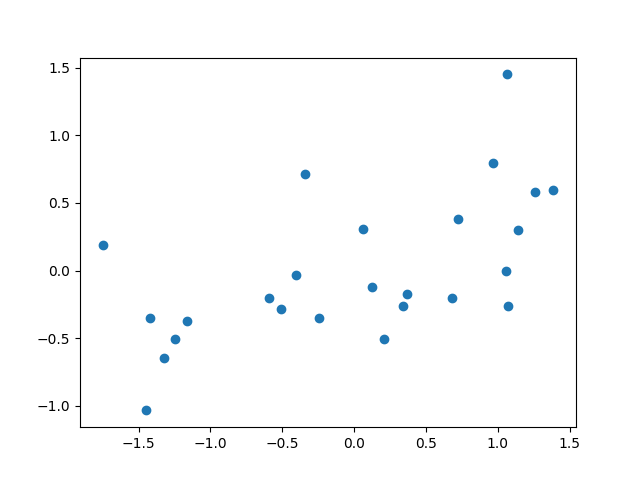

In [8]:
# 5. Dimension reduction
k = 2
R = np.matmul(X, sorted_eigenvectors[:, :k])
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.scatter(R[:,0], R[:,1])
plt.show()

In step 3. above we used the Numpy package's `np.linalg.eig(C)` functionality to compute the eigenpairs for our covariance matrix. 
In step 4. we ordered these eigenpairs by decreasing eigenvalues which gave us our principal componenents. 
In step 5. we multiplied our original dataset by our first two principal componenets to give us a new dataset $R$ with only two features.  

Another value we computed was `Explained variance` which is simply the eigenvalues normalized into a range from 0 to 1. 
Note that by keeping only the first two principal components of our data we are capturing a total of 99.4% of the variance within our dataset. 
This is expected as for our third feature `x3` was derived from both `x1` and `x2`, with a small amount of noise. 

## A Deeper Dive

Before concluding let's look a bit more into why its the eigenpairs of our data's covariance matrix which gives us our principal components. 
First recall in step 1. we mean centered our original dataset. It follows that if our dataset $X$ is mean centered then the covariance matrix is related to $X$ in the following way:
$$
C = \frac{1}{n}X^TX
$$
where $X^T$ is the transpose of $X$. 

### Singluar Value Decomposition - SVD

The SVD of a matrix $X$ is a decomposition of $X$ into 3 special matrices:
$$
X = U \Sigma V^T
$$
where 
- $U$ is the left singular value vectors, a $n \times n$ matrix,
- $\Sigma$ is a real, non-negative valued diagonal matrix (zeros off the main diagonal - contains 0s below if $n \geq m$), a $m \times n$ matrix, and
- $V$ is the right singular value vectors, a $m \times m$ matrix.

There are other notable properties are:
1. The order of $u_1, u_2, ..., u_n$ is such that $u_1$ describes the variance in the cols of $X$ more than $u_2, ..., u_n$, $u_2$ describes the variance in the cols of $X$ more than $u_3, ...$, and so on.
2. $U$ and $V$ are unitary matrices such that $U^TU = V^TV = I$ (the identity matrix.)
3. The entries of $\Sigma$ are $\sigma_1, \sigma_2, ...$ and are ordered such that $\sigma_1 \geq \sigma_2 \geq ... \geq 0$.
4. Columns within $U$ and $V$ are orthonormal.

We now see how the SVD of our dataset relates to its principal components. 
First we mean center our dataset. We then compute $X^TX$ using the SVD of $X$
$$\begin{aligned}
X^TX &= (U \Sigma V^T)^T (U \Sigma V^T) \\
&= V \Sigma^T U^T U \Sigma V^T \\
&= V \Sigma^T \Sigma V^T \\
&= V D V^T
\end{aligned}$$

where $D = \Sigma^T \Sigma$ is a diagonal with squares of singular values and making note of $U$ being a unitary matrix. 

Now we compute $(X^TX)V$ using the above

$$\begin{aligned}
(X^TX)V &= (V D V^T) V \\
(X^TX)V &= V D
\end{aligned}$$
as $V$ is a unitary matrix. 

We now observe that $V$ is the eigenvectors of, not our dataset $X$, but $X^TX$ (here we've stacked all eigenvectors and eigenvalues into matrices) and that $D$ contains our eigenvalues (which are $\sigma_1^2, \sigma_2^2, ...$).
But since our dataset is mean centered, we know that $X^TX = nC$ our dataset's covariance matrix scaled by $n$.

$$\begin{aligned}
nCV &= V D \\
CV &= V \frac{1}{n}D
\end{aligned}$$

This is why we use the eigenvectors of the covariance matrix in decreasing order of eigenvalues as our principal components.

## Conclusion

In this notebook we defined what PCA is and explored how it could be used to reduce a 3 dimensional dataset down to 2 dimensions while minimizing the amount of information lost.
We then explored deeper into how our principal components were related to the covariance matrix of our dataset and its eigenvectors. 